## Исследование точности опредления параллаксов в каталоге Gaia DR3

[Gaia DR3](https://gea.esac.esa.int/archive/documentation/GDR3/) &mdash; третий релиз каталога звездных объектов, созданный на основе результатов, полученных космическим телескопом Gaia. 

Несмотря на огромную пользу этого каталога, ввиду большого объема данных и автоматической их обработки, в предоставляемых результатах могут содержаться существенные ошибки. С другой стороны, одной из самых сложных задач в астрономии является именно определение расстояний. Как следствие, логично ожидать, что значимые ошибки будут именно в связанных с этим понятиях.

Расстояние до объекта связано с [параллаксом](https://en.wikipedia.org/wiki/Parallax) следующим образом:
$$d(пк) = \dfrac{1}{\pi''}.$$

Ввиду большой удаленности [квазары](https://en.wikipedia.org/wiki/Quasar) не имеют параллаксов (на этом основаны современные системы небесных координат). Проверим данное утверждение


In [283]:
import numpy as np
from scipy import stats

from astroquery.gaia import Gaia
import matplotlib.pyplot as plt

In [284]:
# Исследуем union_num равномерно распределенных областей неба?
union_flag = False
union_num = 5

In [285]:
fov = 10 # радиус области в градусах
pr = 0.9973 # уровень значимости вероятности, что объект принадлежит к какому-то типу 

cols = "SOURCE_ID, ra, dec, \
		parallax, parallax_error, parallax_over_error"
# cols = "*"

tbl = "gaiadr3.gaia_source"

only_quasars = f"classprob_dsc_combmod_quasar > {pr}"
only_with_parallax = "parallax IS NOT NULL"

if not union_flag:
	RA = np.random.uniform(0, 360)
	DEC = np.random.uniform(-90, 90)
	# направление на галактический центр 
	# RA = 266.41683
	# DEC = -29.007805
	sky_area = f"CIRCLE('ICRS', {RA}, {DEC}, {fov})"

	query = f"SELECT {cols} \
			FROM {tbl} \
			WHERE \
				CONTAINS(POINT('ICRS', ra, dec), {sky_area}) = 1 \
				AND {only_with_parallax} \
				AND {only_quasars} \
			"
else:
	# union_num (примерно) равномерно распределенных областей на сфере
	query = ""

	for i in range(union_num):
		phi = np.pi * (1 + np.sqrt(5)) * i
		theta = np.arccos(1 - 2 * (i + 0.5) / union_num)
		RA = np.rad2deg(phi % 2*np.pi)
		DEC = np.rad2deg(np.pi/2 - theta)
		sky_area = f"CIRCLE('ICRS', {RA}, {DEC}, {fov})"

		if i != 0: query += " UNION "
		query += f"SELECT {cols} \
				FROM {tbl} \
				WHERE \
					CONTAINS(POINT('ICRS', ra, dec), {sky_area}) = 1 \
					AND {only_with_parallax} \
					AND {only_quasars} \
				"

# отправляем SQL запрос в базу данных Gaia
job = Gaia.launch_job(query, dump_to_file=False)
gaiat = job.get_results()

tb_size = len(gaiat)
gaiat.add_column(np.arange(tb_size), name="ind", index=0)

display(gaiat)

ind,SOURCE_ID,ra,dec,parallax,parallax_error,parallax_over_error
,,deg,deg,mas,mas,
int64,int64,float64,float64,float64,float32,float32
0,1132487974358269952,144.78354924198186,80.06949719813564,-0.2699281639546984,0.5854697,-0.46104547
1,1720515593280907520,224.85688082485495,79.70007066753733,-0.011167723832619499,0.58908385,-0.018957784
2,1145927171841584256,133.09542651110087,82.59399874696717,-0.2409790558805997,0.592121,-0.40697604
3,1716476670460302848,200.04169336399997,77.43833185130102,0.06360586065581626,0.69354457,0.09171128
4,1711603428767122944,209.0584429162576,73.8923844543702,0.3964378032847823,0.46363735,0.8550601
5,2304976113020698752,306.6590982520361,87.47127641977832,2.2306161793358164,0.5428165,4.1093373
6,1708693506821425920,237.85806240917668,79.71658179466313,-0.31223772510975967,0.48023432,-0.65017784
7,1152851582540392064,119.71851233381324,88.96515630035377,2.872167934690975,1.163156,2.4692886


Как видно, параллаксы есть и иногда достаточно большие... 

Однако, являются ли они статистически значимыми? Простейшая оценка значимости параллаксов:

In [286]:
n_sigm = 3

gaiat["stat_sign_par"] = abs(gaiat["parallax_over_error"]) > n_sigm

perc_stat = len(gaiat[gaiat["stat_sign_par"]]) / tb_size
perc_neg = len(gaiat[gaiat["parallax"] < 0]) / tb_size
perc_neg_stat = len(gaiat[(gaiat["parallax"] < 0) & gaiat["stat_sign_par"]]) / len(gaiat[gaiat["parallax"] < 0])

print(f"Доля статистически значимых ({n_sigm} sigma) параллаксов в выборке = {perc_stat:.2%}")
print(f"Доля отрицательных параллаксов в выборке = {perc_neg:.2%}")
print(f"Доля статистически значимых ({n_sigm} sigma) среди отрицательных параллаксов = {perc_neg_stat:.2%}")

# display(gaiat)

Доля статистически значимых (3 sigma) параллаксов в выборке = 7.25%
Доля отрицательных параллаксов в выборке = 46.90%
Доля статистически значимых (3 sigma) среди отрицательных параллаксов = 0.21%


Примерно половина параллаксов отрицательна, а значимых очень мало. Следовательно, можно ожидать их нормальное распределение вокруг нуля &mdash; просто из-за наличия ошибок измерений. Рассмотрим данную [нулевую гипотезу](https://en.wikipedia.org/wiki/Null_hypothesis) 

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_8130/2568491479.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, "k", linewidth=2, label=f"norm distr\n$\mu$ = {mu:.2f}\n$\sigma$ = {std:.2f}")
/tmp/ipykernel_8130/2568491479.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, "k", linewidth=2, label=f"norm distr\n$\mu$ = {mu:.2f}\n$\sigma$ = {std:.2f}")


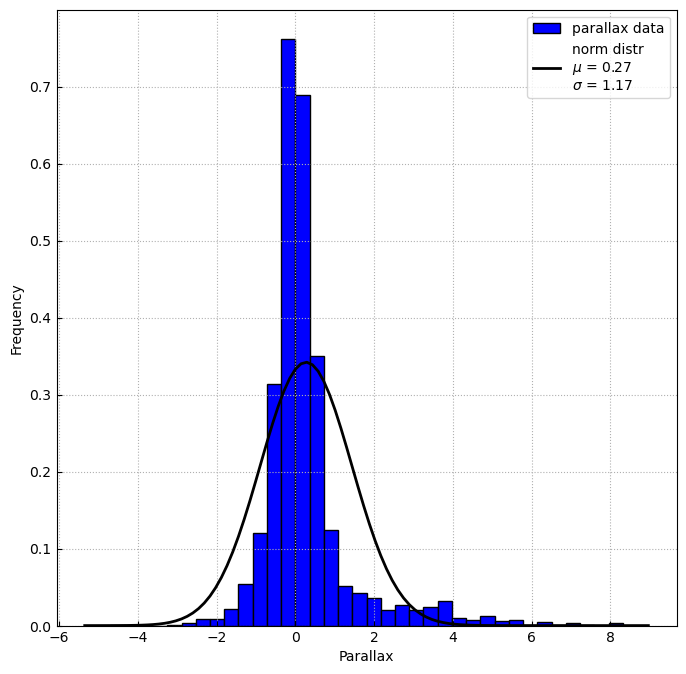

In [287]:
# находим мат. ожидание и дисперсию
mu, std = stats.norm.fit(gaiat["parallax"]) 

plt.close()
plt.figure(figsize=(8,8))

plt.hist(gaiat["parallax"], density=True, color="blue", edgecolor="black", bins=int(180/5), label="parallax data")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, "k", linewidth=2, label=f"norm distr\n$\mu$ = {mu:.2f}\n$\sigma$ = {std:.2f}")

plt.grid(linestyle=":")
plt.tick_params(which="both", direction="in")
plt.xlabel("Parallax")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Как видно, распределение похоже на нормальное только в очень грубой оценке (также переодически наблюдается существенная ассиметрия и сильное отличие мат. ожидания от 0). Проверим нормальность численно с помощью `p-value` при критерии значимости $\alpha = 0.05$

In [288]:
# Критерий Колмогорова-Смирнова
res1 = stats.kstest(gaiat["parallax"], stats.norm(loc=mu, scale=std).cdf)
# Критерий Шапиро-Уилка
res2 = stats.shapiro(gaiat["parallax"]) 
# Критерий Д'Агостино-Пирсона
res3 = stats.normaltest(gaiat["parallax"]) 

print(f"Значение p-value полученное тестом Колмогорова-Смирнова: {res1.pvalue:.3e}")
print(f"Значение p-value полученное тестом Шапиро-Уилка: {res2.pvalue:.3e}")
print(f"Значение p-value полученное тестом Д'Агостино-Пирсона: {res3.pvalue:.3e}")

Значение p-value полученное тестом Колмогорова-Смирнова: 1.371e-71
Значение p-value полученное тестом Шапиро-Уилка: 2.318e-47
Значение p-value полученное тестом Д'Агостино-Пирсона: 1.104e-237


Во всех тестах `p-value` < $\alpha$. Можно заключить, что наблюдаемое распределение параллаксов существенно не нормальное, хоть и визуально похоже на него. Описать подобные распределения можно [эксцессом и ассиметрией](https://www.geeksforgeeks.org/difference-between-skewness-and-kurtosis/):

In [289]:
# Ассиметрия и эксцесс
ske = stats.skew(gaiat["parallax"])
kur = stats.kurtosis(gaiat["parallax"])

print(f"Ассиметрия = {ske:.2f}")
print(f"Эксцесс = {kur:.2f}")

Ассиметрия = 2.45
Эксцесс = 9.34


## Вывод

Наблюдаемые параллаксы квазаров должны хорошо описываться нормальным распредлением с нулевым мат. ожиданием. Для квазаров из каталога Gaia, как было показано, это не так. Иногда мат. ожидание, ассиметри или эксцесс близки к нормальному распределению, но качетсвенно несоответствие (опряделяемое разнличными тестами) наблюдается в любой области небесной сферы (для любой выборки данных). Причем смещение параметров всегда в положительную сторону. 

Из этого можно сделать вывод, что присутствует некоторая общая систематическая ошибка в способе определения параллаксов. А, значит, неточности будут наблюдаться и у других объектов и связанных с параллаксом параметрами. Это необходимо всегда помнить и учитывать в исследованиях.